# Метод опорных векторов для задачи регресии

## Данные
Испытания бетона на осадку. Проверка, насколько правильно было выполнено смешение компонентов для бетона. В ходе испытания бетон заливают в конус, после чего бытсро переворачивают и снимают конус. После чего смотрят насколько получившаяся форма из бетона держит свою форму. Для этого измеряют расстояние между верхней формой конуса и верхней частью формы бетона (осадка бетона slamp, см). flow, см - диаметр пятная, котороый возникает после растекания бетона. Через 28 дней также измеряется прочность уже застывшего бетона. 

Наша задача: у нас есть входные характеристики бетона, а также испытания бетона на осадку. Можем ли мы определить по этим данным, какая прочность будет через 28 дней.

## <font color='green'>Загружаем библиотеки</font>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## <font color='green'>Данные</font>

In [3]:
df = pd.read_csv('cement_slump.csv')

In [4]:
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   SLUMP(cm)                           103 non-null    float64
 8   FLOW(cm)                            103 non-null    float64
 9   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


Посмотрим корреляцию между признаками и целевой переменной

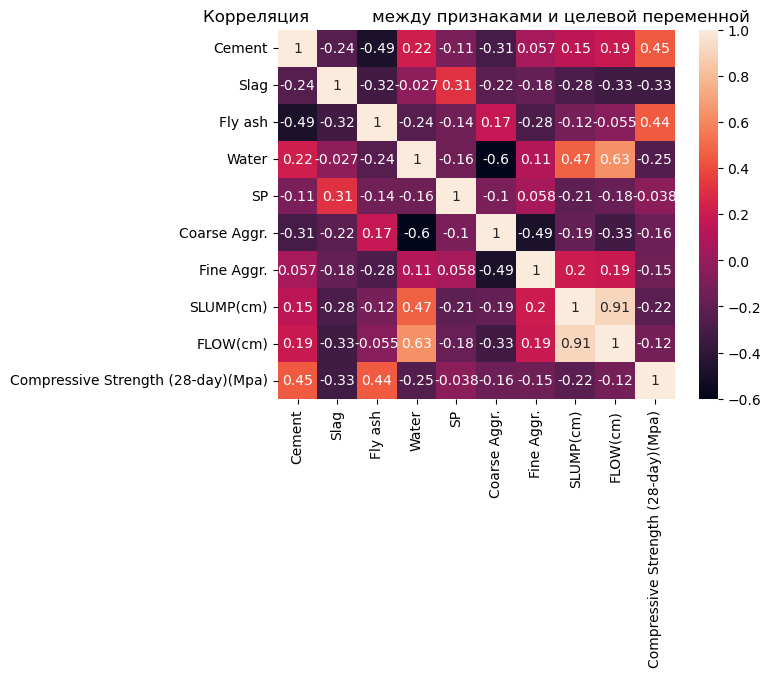

In [6]:
sns.heatmap(df.corr(), 
            annot = True).set_title('Корреляция\
            между признаками и целевой переменной');

Видим, что такие признаки как fly ash и cement коррелируют с целевой переменной

<font color = 'green'>Создание модели </font>

In [7]:
X = df.drop('Compressive Strength (28-day)(Mpa)', axis = 1)
y = df['Compressive Strength (28-day)(Mpa)']

<font color='green'>Разбиение на обучающий и тестовый набор данных, масштабирование</font>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

scaler = StandardScaler()
sc_X_train = scaler.fit_transform(X_train)
sc_X_test = scaler.transform(X_test)

<font color = 'red'>Модель с параметрами по умолчанию</font>

kernel = rbf

degree = 3

gamma = scale

С = 1

epsilon = 0.1

In [9]:
base_model = SVR()

base_model.fit(sc_X_train, y_train)

SVR()

In [10]:
base_preds = base_model.predict(sc_X_test)

<font color = 'green'>Оценка модели</font>

In [11]:
a = mean_absolute_error(y_test, base_preds)
b = np.sqrt(mean_squared_error(y_test, base_preds))
c = y_test.mean()

print(f'MAE = {a:.2f}, MSEA = {b:.2f}')
print(f'Compressive Strength (28-day)(Mpa) = {c:.2f}')

MAE = 5.24, MSEA = 6.70
Compressive Strength (28-day)(Mpa) = 36.27


Оценка указывается в тех единицах, в которых указана целевая переменная.

<font color='red'>Модель с параметрами, подобранными с помощью сетки</font>

Создаем параметры для перебора

In [12]:
param_grid = {'C':[0.001, 0.01, 0.1, 0.5, 1],
             'kernel' : ['linear', 'rbf', 'poly'],
             'gamma' : ['scale', 'auto'],
             'degree' : [2,3,4],
             'epsilon': [0, 0.1, 0.2, 0.5, 1, 2]}

In [13]:
# Создаем модель
svr = SVR()

#Применяем поиск по сетке
grid = GridSearchCV(svr, param_grid)

#Обучаем модель
grid.fit(sc_X_train, y_train)

#Определяем лучшие параметры
grid.best_params_

{'C': 1, 'degree': 2, 'epsilon': 2, 'gamma': 'scale', 'kernel': 'linear'}

<font color='red'>Радиальная базисная функция</font>

kernel = rbf (обычно идет как значение по умолчанию)

С = 1, некоторое среднее значение. Если делать С меньше, то в пространстве между зазором и разделяющей линией будет больше точек

Итог: такое ядро берет наши данные и проецирует их в пространство с бОльшей размерностью, поэтому когда мы проецируем нашу плоскость обратно в наше исходное пространство, то это уже не будет выглядеть как прямая, а как кривая линия. Зазоры теперь строятся вокруг наших кластеров с точками.

In [14]:
grid_preds = grid.predict(sc_X_test)

<font color = 'green'>Оценка модели</font>

In [15]:
a = mean_absolute_error(y_test, grid_preds)
b = np.sqrt(mean_squared_error(y_test, grid_preds))
c = y_test.mean()

print(f'MAE = {a:.2f}, MSEA = {b:.2f}')
print(f'Compressive Strength (28-day)(Mpa) = {c:.2f}')

MAE = 2.51, MSEA = 3.18
Compressive Strength (28-day)(Mpa) = 36.27


Наблюдаем значительное улучшение по сравнению с базовой моделью